In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

In [4]:
def assign_param_search_sector(df, kind, thresh, top='splicing_ratio', rm_simple=False):
    """
    Assign each gene triplet a sector based on 
    altering one threshold

    Parameters:
        df (pandas DataFrame): DataFrame with simplex coordinates and n_iso
        kind (str): 'tss', 'ic', 'tes'
        thresh (float): Threshold to use
        top: (str): {'splicing_ratio', 'n_ic'}
        rm_simple (bool): Whether to remove simple genes

    Returns:
        df (pandas DataFrame): DataFrame with sector listed
    """
    temp = df.copy(deep=True)
    
    if kind == 'tss':
        thing = 'tss_ratio'
        thing2 = 'tss'
    elif kind == 'ic':
        thing = 'spl_ratio'
        thing2 = 'splicing'
    elif kind == 'tes':
        thing = 'tes_ratio'
        thing2 = 'tes'
        
    if top == 'n_ic':
        # recalc
        temp['tss_ratio'] = temp.n_tss/(temp.n_tss+temp.n_ic+temp.n_tes)
        temp['spl_ratio'] = temp.n_ic/(temp.n_tss+temp.n_ic+temp.n_tes)
        temp['tes_ratio'] = temp.n_tes/(temp.n_tss+temp.n_ic+temp.n_tes)
        
    # df['sector'] = f'not_{thing2}'
    temp['sector'] = np.nan

    temp.loc[temp[thing] > thresh, 'sector'] = thing2
    
    # remove single-isoform genes, if requested
    if rm_simple:
        temp = temp.loc[temp.n_iso != 1]
    
    return temp

In [18]:
ca = cerberus.read(cerberus_h5)
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='obs_det']

In [25]:
gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
df = df.merge(gtf_df[['gid_stable', 'biotype_category']],
              how='left',
              left_on='gid',
              right_on='gid_stable')
df = df.loc[df.biotype_category==gene_subset]

In [28]:
print(df[['sector', 'gid']].groupby('sector').count())

           gid
sector        
mixed     7880
simple    1896
splicing  1113
tes       4527
tss       2017


## w/o splicing ratio

In [8]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh, top='n_ic')
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)

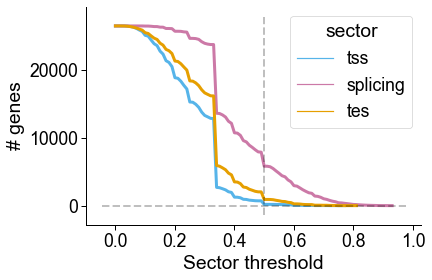

In [9]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.lineplot(big_df, hue='sector', y='n_genes', x='thresh', linewidth=3, palette=c_dict)
ax.set(xlabel='Sector threshold', ylabel='# genes')
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.vlines(0.5, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
ax.hlines(0, xlims[0], xlims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [10]:
big_df.head()

,sector,n_genes,feat,thresh
0,tss,26544,tss,0.00
0,tss,26544,tss,0.01
0,tss,26543,tss,0.02
0,tss,26541,tss,0.03
0,tss,26515,tss,0.04


In [11]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
0,obs_det,ENSG00000000003,1.0,6.0,9.0,29.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN
2,obs_det,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,mixed,DPM1,NaN,NaN
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN
4,obs_det,ENSG00000000460,3.0,4.0,6.0,17.0,1.714286,0.344262,0.459016,0.196721,mixed,C1orf112,NaN,NaN


## w/ splicing ratio

In [12]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh)
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)

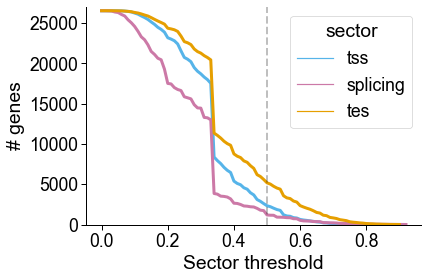

In [13]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.lineplot(big_df, hue='sector', y='n_genes', x='thresh', linewidth=3, palette=c_dict)
ax.set(xlabel='Sector threshold', ylabel='# genes', ylim=(0,27000))
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.vlines(0.5, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
# ax.hlines(0, xlims[0], xlims[1],
#                       colors='k', linestyles='dashed',
#                       linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:
big_df.head()

,sector,n_genes,feat,thresh
0,tss,26544,tss,0.00
0,tss,26544,tss,0.01
0,tss,26544,tss,0.02
0,tss,26544,tss,0.03
0,tss,26542,tss,0.04


## w/ splicing ratio and w/o simple genes

In [34]:
n_non_simple = len(df.loc[df.sector!='simple'].index)

In [36]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh, rm_simple=True)
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)
big_df['total_genes'] = n_non_simple

In [38]:
big_df.head()
big_df['perc'] = (big_df.n_genes/big_df.total_genes)*100
big_df.head()

,sector,n_genes,feat,thresh,total_genes,perc
0,tss,15537,tss,0.00,15537,100.000000
0,tss,15537,tss,0.01,15537,100.000000
0,tss,15537,tss,0.02,15537,100.000000
0,tss,15537,tss,0.03,15537,100.000000
0,tss,15535,tss,0.04,15537,99.987128


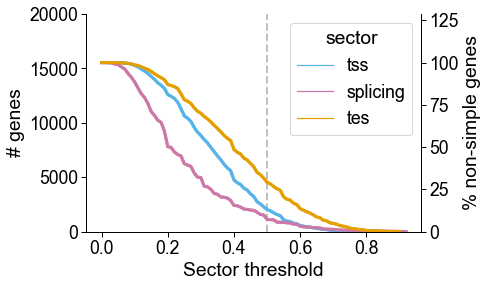

In [47]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1 = sns.lineplot(big_df, hue='sector',
                  y='n_genes', x='thresh', linewidth=3,
                  palette=c_dict, ax=ax1)
ax2 = sns.lineplot(big_df, hue='sector',
                  y='perc', x='thresh', linewidth=3,
                  palette=c_dict, ax=ax2)

max_1 = 20000
max_2 = (100*20000)/big_df.total_genes.tolist()[0]
ax1.set(xlabel='Sector threshold', ylabel='# genes', ylim=(0,max_1))
ax2.set(xlabel='Sector threshold', ylabel='% non-simple genes', ylim=(0,max_2))
ylims = ax1.get_ylim()
xlims = ax1.get_xlim()

ax1.vlines(0.50, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
# ax.hlines(0, xlims[0], xlims[1],
#                       colors='k', linestyles='dashed',
#                       linewidth=2, alpha=0.25)
# ax.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

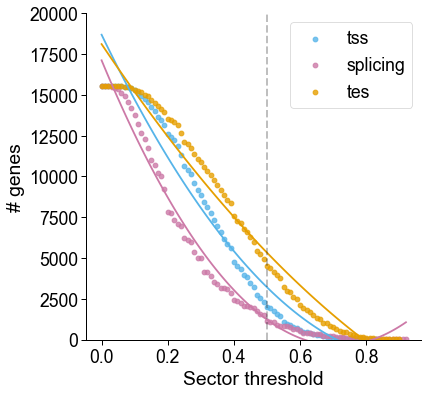

In [60]:
# fit regression lines to these curves
# create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# add the plots for each dataframe
for s in big_df.sector.unique():
    temp = big_df.loc[big_df.sector==s].copy(deep=True)
    sns.regplot(temp, x='thresh', y='n_genes',
                fit_reg=True, ci=None, ax=ax, label=s,
                color=c_dict[s], order=2)
ax.legend()
ax.set(xlabel='Sector threshold', ylabel='# genes', ylim=(0,max_1))
ylims = ax1.get_ylim()
xlims = ax1.get_xlim()

ax.vlines(0.50, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [14]:
# get numbers at 0.3 and 0.7?
big_df.head()
nums = [0.3, 0.4, 0.5, 0.6, 0.7]
for num in nums:
    print(big_df.loc[big_df.thresh.isin([num])])
    print()

     sector  n_genes feat  thresh
0       tss     9966  tss     0.3
0  splicing     5710   ic     0.3
0       tes    12539  tes     0.3

     sector  n_genes feat  thresh
0       tss     5387  tss     0.4
0  splicing     2643   ic     0.4
0       tes     8766  tes     0.4

     sector  n_genes feat  thresh
0       tss     2328  tss     0.5
0  splicing     1182   ic     0.5
0       tes     5174  tes     0.5

     sector  n_genes feat  thresh
0       tss      630  tss     0.6
0  splicing      517   ic     0.6
0       tes     2346  tes     0.6

     sector  n_genes feat  thresh
0       tss      124  tss     0.7
0  splicing      206   ic     0.7
0       tes      820  tes     0.7



## w/o splicing ratio and w/o simple genes

In [18]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh, rm_simple=True, top='n_ic')
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)

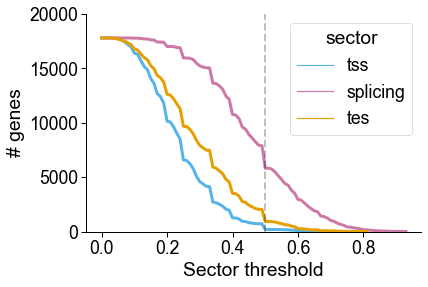

In [19]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.lineplot(big_df, hue='sector', y='n_genes', x='thresh', linewidth=3, palette=c_dict)
ax.set(xlabel='Sector threshold', ylabel='# genes', ylim=(0,20000))
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.vlines(0.50, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
# ax.hlines(0, xlims[0], xlims[1],
#                       colors='k', linestyles='dashed',
#                       linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)